# FTML Project

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import optuna


X_train = np.load("../data/classification/X_train.npy")
X_test = np.load("../data/classification/X_test.npy")
Y_train = np.load("../data/classification/y_train.npy")
Y_test = np.load("../data/classification/y_test.npy")

## KNeighbors

best K:  43
score:  0.799


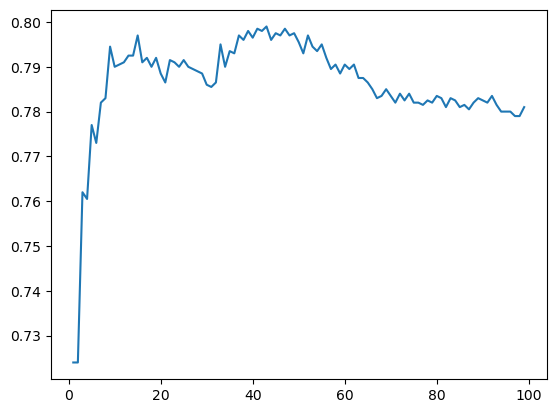

In [49]:
scores = []
ks = list(range(1, 100))

for k in ks:
    model = KNeighborsClassifier(n_neighbors = k, weights="distance", n_jobs=-1)
    model.fit(X_train, Y_train)
    score = model.score(X_test, Y_test)
    
    scores.append(score)

plt.plot(ks, scores)
print("best K: ", ks[np.argmax(scores)])
print("score: ", max(scores))

## LogisticRegression

In [33]:
model = LogisticRegression()
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("score: ", score)

score:  0.7435


## SVC

In [101]:
model = make_pipeline(StandardScaler(), SVC())
model.fit(X_train_scaled, Y_train)
score = model.score(X_test_scaled, Y_test)

print("score: ", score)

score:  0.7925


## MLPClassifier

In [66]:
model = MLPClassifier(max_iter=500, early_stopping=True)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("score: ", score)

score:  0.76


## AdaBoostClassifier

## GradientBoostingClassifier

In [20]:
model = GradientBoostingClassifier()
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("score: ", score)

score:  0.7605


In [44]:
model = AdaBoostClassifier()
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("score: ", score)

score:  0.7355


# Hyperparameter tuning with optuna


## SVC
SVC had the highest score by default so we will optimise this model.

Conclusion: SVC default parameters are the best we can expect.

In [16]:
def objective(trial):
    C = trial.suggest_float('C', 0, 1)
    degree = trial.suggest_int('degree', 1, 10)
    kernel = trial.suggest_categorical('kernel',['linear', 'poly', 'rbf', 'sigmoid'])
    gamma = trial.suggest_categorical('gamma',['scale', 'auto'])
    
    
    model = make_pipeline(StandardScaler(), SVC(C=C, degree=degree, kernel=kernel, gamma=gamma))
    model.fit(X_train, Y_train)
    score = model.score(X_test, Y_test)
    return score

study = optuna.create_study(study_name="SVC hyperparameter optimisation v2", direction="maximize")
study.optimize(objective, n_trials=300)

study.best_params

[I 2025-06-01 16:17:33,902] A new study created in memory with name: SVC hyperparameter optimisation v2
[I 2025-06-01 16:17:34,303] Trial 0 finished with value: 0.606 and parameters: {'C': 0.4780402571926753, 'degree': 6, 'kernel': 'poly', 'gamma': 'auto'}. Best is trial 0 with value: 0.606.
[I 2025-06-01 16:17:34,676] Trial 1 finished with value: 0.716 and parameters: {'C': 0.7311306765651996, 'degree': 2, 'kernel': 'sigmoid', 'gamma': 'scale'}. Best is trial 1 with value: 0.716.
[I 2025-06-01 16:17:35,010] Trial 2 finished with value: 0.674 and parameters: {'C': 0.2635108439467828, 'degree': 5, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 1 with value: 0.716.
[I 2025-06-01 16:17:35,404] Trial 3 finished with value: 0.602 and parameters: {'C': 0.5485267889055908, 'degree': 7, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 1 with value: 0.716.
[I 2025-06-01 16:17:35,756] Trial 4 finished with value: 0.749 and parameters: {'C': 0.731099735715622, 'degree': 6, 'kernel': 'linear

{'C': 0.999690551085025, 'degree': 10, 'kernel': 'rbf', 'gamma': 'auto'}

## GradientBoostingClassifier

In [ ]:
def objective(trial):
    subsample = trial.suggest_float('subsample', 0, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    n_estimators = trial.suggest_int('n_estimators', 1, 300)
    loss = trial.suggest_categorical('loss',['log_loss', 'exponential'])
    
    
    model = GradientBoostingClassifier(subsample=subsample, learning_rate=learning_rate, n_estimators=n_estimators, loss=loss)
    model.fit(X_train, Y_train)
    score = model.score(X_test, Y_test)
    return score

study = optuna.create_study(study_name="GradientBoostingClassifier hyperparameter optimisation ", direction="maximize")
study.optimize(objective, n_trials=300)

study.best_params

[I 2025-06-01 16:24:10,694] A new study created in memory with name: GradientBoostingClassifier hyperparameter optimisation 
[I 2025-06-01 16:24:12,545] Trial 0 finished with value: 0.7175 and parameters: {'subsample': 0.5710151979402134, 'learning_rate': 0.3985119450650667, 'n_estimators': 131, 'loss': 'log_loss'}. Best is trial 0 with value: 0.7175.
[I 2025-06-01 16:24:13,017] Trial 1 finished with value: 0.691 and parameters: {'subsample': 0.5694176848656171, 'learning_rate': 0.8805810902024276, 'n_estimators': 33, 'loss': 'log_loss'}. Best is trial 0 with value: 0.7175.
[I 2025-06-01 16:24:13,314] Trial 2 finished with value: 0.674 and parameters: {'subsample': 0.01117646264056249, 'learning_rate': 0.22289539160900973, 'n_estimators': 202, 'loss': 'exponential'}. Best is trial 0 with value: 0.7175.
[I 2025-06-01 16:24:15,679] Trial 3 finished with value: 0.745 and parameters: {'subsample': 0.6685737319035788, 'learning_rate': 0.2917811474436589, 'n_estimators': 145, 'loss': 'log_lo